In [23]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

**Building a Decision Tree Classifier**

In [24]:
# Load data
data = pd.read_csv("bank_marketing_cleaned.csv")

# data (as pandas dataframes) 
X = data.drop(columns=['y', 'duration'])
y = data['y']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Display columns
print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocessing pipelines: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Define model
dt = DecisionTreeClassifier(random_state=42)

# Pipeline
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ("smote", SMOTE(random_state=42)),
    ('classifier', dt)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid
parameter_grid = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_leaf': [1, 5, 20],
    'classifier__min_samples_split': [2, 10, 50]
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(pipeline, parameter_grid, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_search.fit(X_train, y_train)

# Best params and score
print("Best parameters:", grid_search.best_params_)
print("Best CV ROC AUC:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob, pos_label='yes')    

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numeric columns: ['age', 'balance', 'day_of_week', 'campaign', 'pdays', 'previous']
Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 20, 'classifier__min_samples_split': 50}
Best CV ROC AUC: 0.7660329851155246
Test Accuracy: 0.8669485202685899
Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.91      0.92      7215
         yes       0.39      0.49      0.43       827

    accuracy                           0.87      8042
   macro avg       0.66      0.70      0.68      8042
weighted avg       0.88      0.87      0.87      8042

Test ROC AUC: 0.7656241489373291


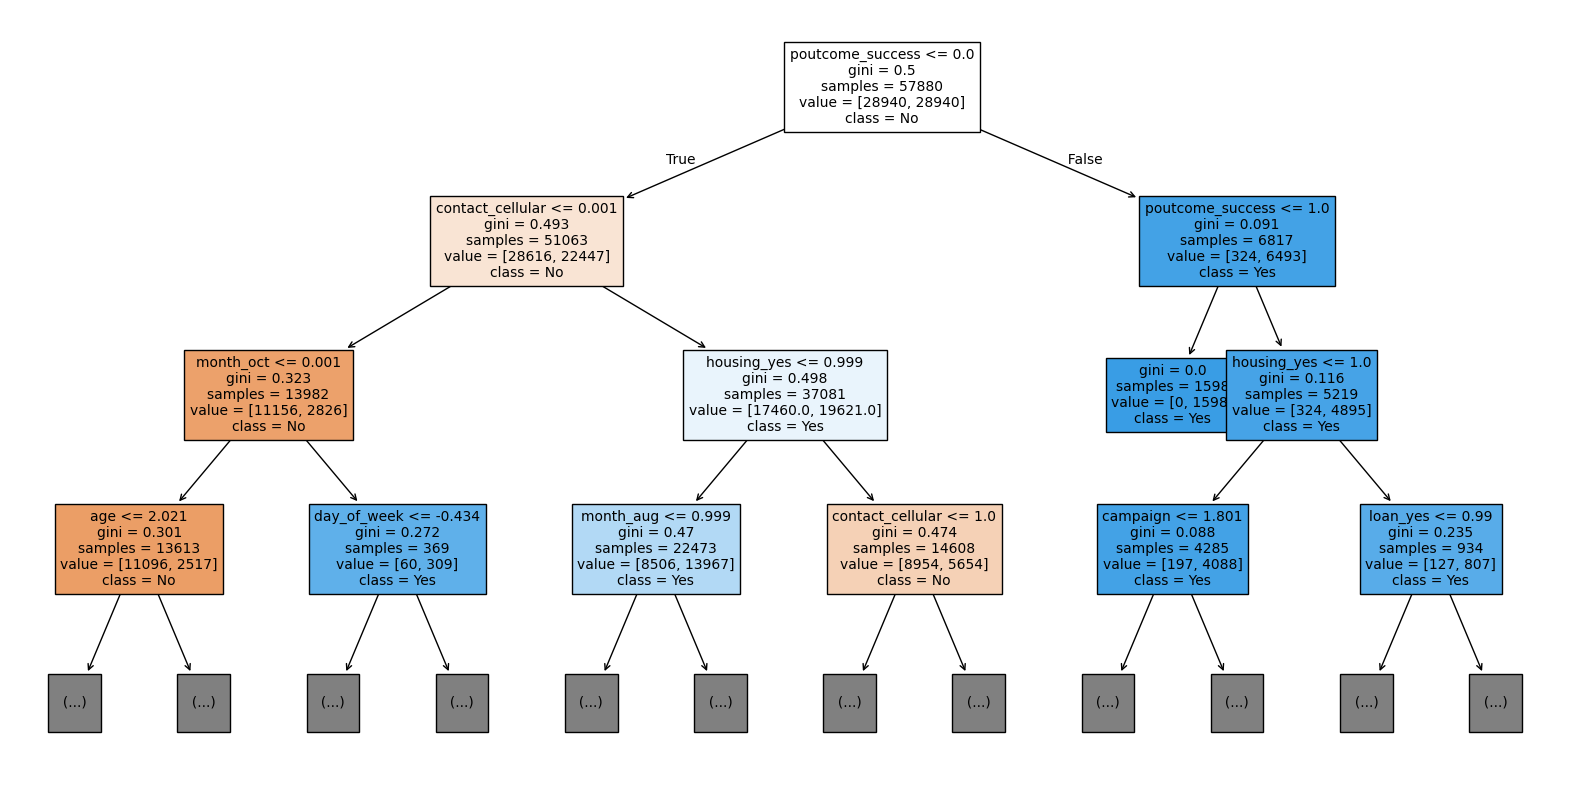

In [25]:
# Visualize tree
final_tree = best_model.named_steps["classifier"]

# Get feature names after one-hot encoding
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
feature_names = numeric_cols + list(ohe_feature_names)

plt.figure(figsize=(20,10))
plot_tree(final_tree, filled=True, feature_names=feature_names, class_names=["No","Yes"], max_depth=3, fontsize=10)
plt.show()

**Comparing with random forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Load data
data = pd.read_csv("bank_marketing_cleaned.csv")

X = data.drop(columns=['y', 'duration'])
y = data['y']

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocessing pipelines: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Define model
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)

# Pipeline with SMOTE
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', rf)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter grid
parameter_grid = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 10, 50],
    'classifier__min_samples_leaf': [1, 5, 20],
    'classifier__max_features': ['sqrt', 'log2']
}

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    pipeline,
    parameter_grid,
    cv=5,
    n_jobs=-1,
    scoring='roc_auc',
    verbose=2
)
grid_search.fit(X_train, y_train)

# Best params and score
print("Best parameters:", grid_search.best_params_)
print("Best CV ROC AUC:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_prob))